**HuBMAP - Hacking the Human Vasculature**

Segment instances of microvascular structures from healthy human kidney tissue slides.

**Goal of the Competition**

The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. You'll create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

Your help in automating the segmentation of microvasculature structures will improve researchers' understanding of how the blood vessels are arranged in human tissues.

**Context**

The proper functioning of your body's organs and tissues depends on the interaction, spatial organization, and specialization of your cells—all 37 trillion of them. With so many cells, determining their functions and relationships is a monumental undertaking.

Current efforts to map cells involve the Vasculature Common Coordinate Framework (VCCF), which uses the blood vasculature in the human body as the primary navigation system. The VCCF crosses all scale levels--from the whole body to the single cell level--and provides a unique way to identify cellular locations using capillary structures as an address. However, the gaps in what researchers know about microvasculature lead to gaps in the VCCF. If we could automatically segment microvasculature arrangements, researchers could use the real-world tissue data to begin to fill in those gaps and map out the vasculature.

Competition host Human BioMolecular Atlas Program (HuBMAP) hopes to develop an open and global platform to map healthy cells in the human body. Using the latest molecular and cellular biology technologies, HuBMAP researchers are studying the connections that cells have with each other throughout the body.

There are still many unknowns regarding microvasculature, but your Machine Learning insights could enable researchers to use the available tissue data to augment their understanding of how these small vessels are arranged throughout the body. Ultimately, you'll be helping to pave the way towards building a Vascular Common Coordinate Framework (VCCF) and a Human Reference Atlas (HRA), which will identify how the relationships between cells can affect our health.

In [3]:
!pip install staintools
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14048 sha256=0365036d55c54a12f257d406965b90a0a786ace263abdf72b4b4ad1c60779fea
  Stored in directory: /root/.cache/pip/wheels/83/01/30/d5b79f92442193b7e3229cb20fb8458e765594cc2251f87ae6
Successfully built staintools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp310-cp310-linux_x86_64.whl size=4490032 sha256=87d96d5b8e8f85be88e4c77cb6600d22032c93ead8bff863edd3c9af40172a0b
  Stored in directory: /root/.cache/pip/wheels/67/9d/1f/60a6c60785b07ad4f087297f04b723e6

In [18]:
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import staintools
import pickle
from scipy.ndimage import label

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train = glob.glob("/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/train/*")
test = glob.glob("/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/test/*")

In [7]:
# Create a dictionary to hold the annotations for each image
annotations = {}

# Open the annotations file
with open('/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/polygons.jsonl', 'r') as f:
    # For each line in the file
    for line in f:
        # Parse the line as JSON
        annotation = json.loads(line)

        # Get the image ID and the list of annotations for this image
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        # Store the annotations in the dictionary
        annotations[image_id] = image_annotations

In [8]:
# map images
image_map = {impath.split('/')[-1].split('.')[0]: impath for impath in train}
image_map.update({impath.split('/')[-1].split('.')[0]: impath for impath in test})

Stain normalization use was refrenced from RAVI SHAH ["StainTools for Augmentation"](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/discussion/412396) thank you

Stain normalization is used to adjust the RGB color values to a consistint range

images are also normalized to 0-1

this is still experimental and more preprocessing can be added or changed in future versions

In [9]:
# or load from prevoius preprocessing
with open('/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/preprocessed_images.pkl', 'rb') as f:
    preprocessed_images = pickle.load(f)

In [ ]:
def preprocess_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image = cv2.resize(image, (512 , 512))

    # Normalize image to 0-1
    image = image / 255.0

    
    # Standardize the luminosity
    image_standardized = staintools.LuminosityStandardizer.standardize(image_rgb)

    # Initialize stain normalizer
    normalizer = staintools.StainNormalizer(method='vahadane')

    # Fit on the target image
    normalizer.fit(target_image)

    # Transform the input image
    transformed_image = normalizer.transform(image_standardized)

    return transformed_image

In [ ]:
# Assume the first image in your dataset is the target for stain normalization
target_image_path = image_map[list(image_map.keys())[0]]
target_image = cv2.cvtColor(cv2.imread(target_image_path), cv2.COLOR_BGR2RGB)
target_image = staintools.LuminosityStandardizer.standardize(target_image)

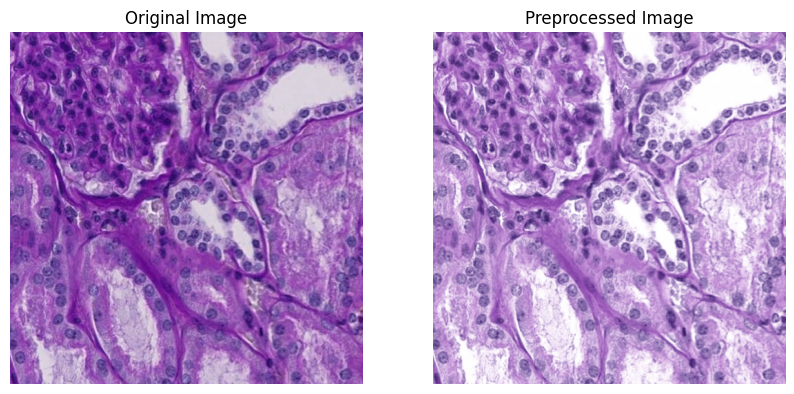

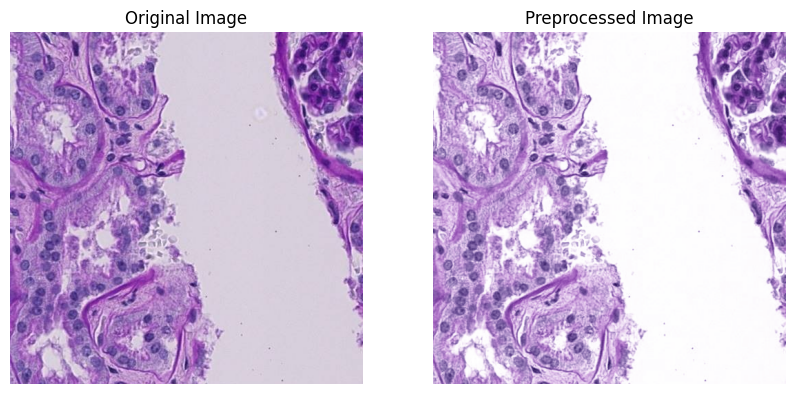

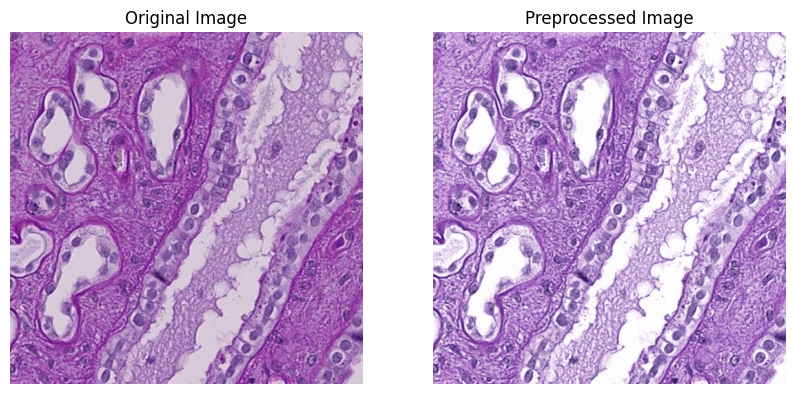

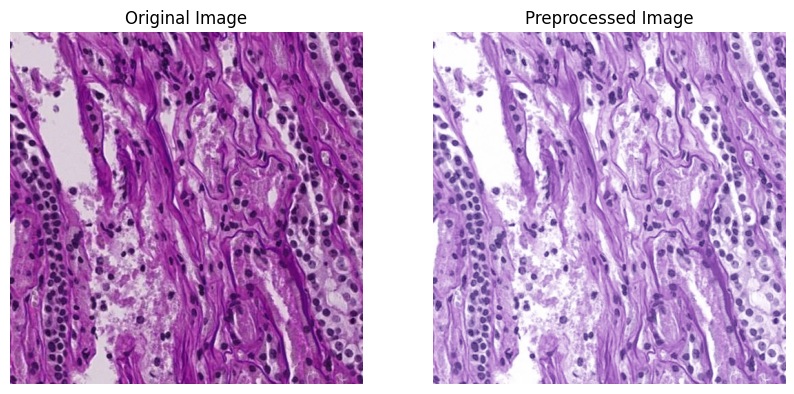

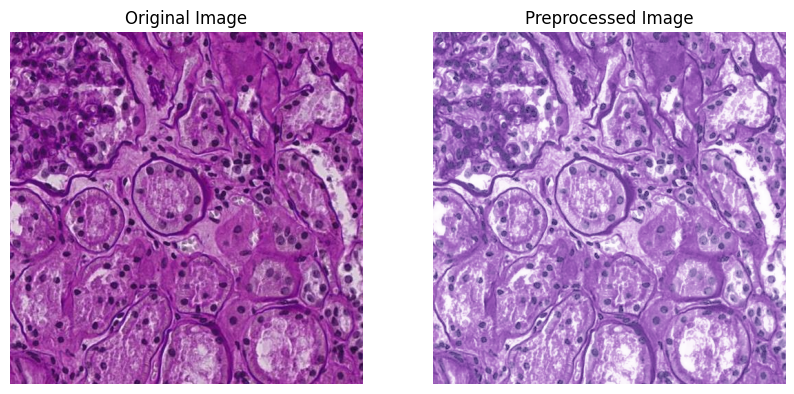

In [ ]:
preprocessed_images = {}
for i, image_id in enumerate(list(blood_vessel_annotations.keys())):
    # Open the image file
    if image_id in image_map:
        image = cv2.imread(image_map[image_id])
        preprocessed_image = preprocess_image(image.copy())
        preprocessed_images[image_id] = preprocessed_image

        # For the first 5 images, display the original and preprocessed image side by side
        if i < 5:
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
            plt.title("Preprocessed Image")
            plt.axis('off')

            plt.show()

In [21]:
def display_images_masks_overlays(image, masks, image_id):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color space before creating overlay
    overlay = image_rgb.copy()
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # colors for blood vessels, glomerulus and unsure respectively

    # Initialize dictionary to hold annotation counts
    annotation_counts = {}
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # Count the number of distinct areas in the mask
        labeled, num_areas = label(mask)
        annotation_counts[annotation_type] = num_areas

        # update overlay
        overlay[mask > 0] = colors[idx-2]

    # print annotation counts
    print(f"Annotation counts for image {image_id}: {annotation_counts}")

    # prepare for subplot
    plt.figure(figsize=(25,5))

    # plot the original image
    plt.subplot(1,5,1)
    plt.imshow(image_rgb)
    plt.title('Image')
    plt.axis('off')
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # plot the binary masks
        plt.subplot(1,5,idx)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{annotation_type} mask')
        plt.axis('off')

    # plot the overlay
    plt.subplot(1,5,5)
    plt.imshow(image_rgb)  # Use RGB image
    plt.imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
    plt.title('Overlay')
    plt.axis('off')
    plt.show()

Annotation counts for image 0006ff2aa7cd: {'blood_vessel': 8, 'glomerulus': 1, 'unsure': 0}


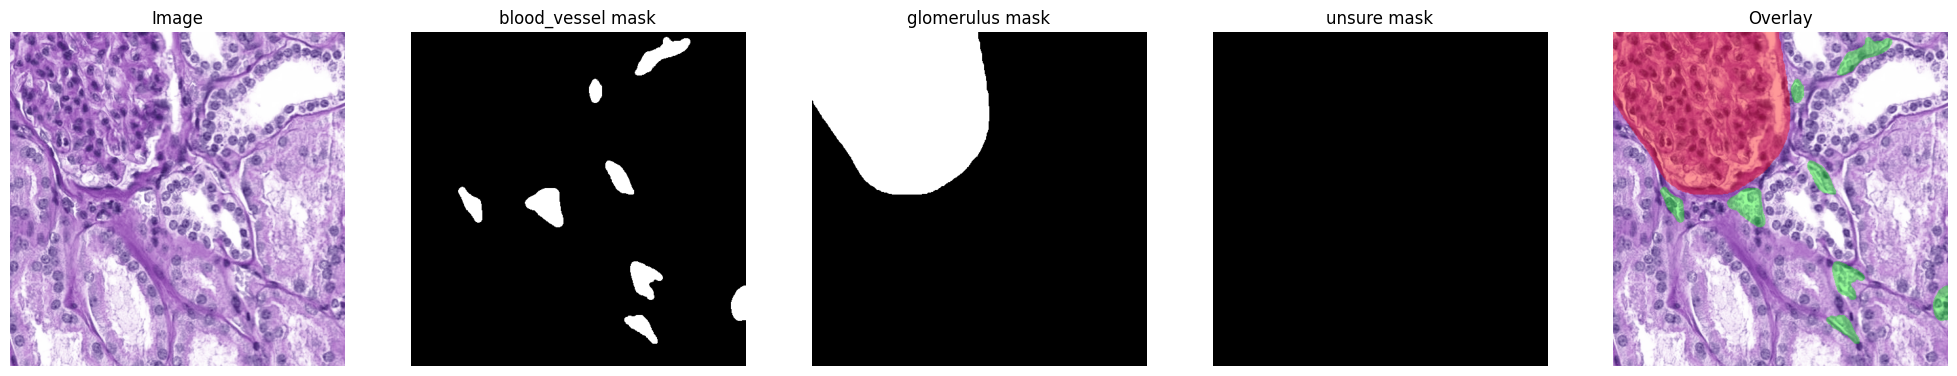

Annotation counts for image 00168d1b7522: {'blood_vessel': 1, 'glomerulus': 1, 'unsure': 0}


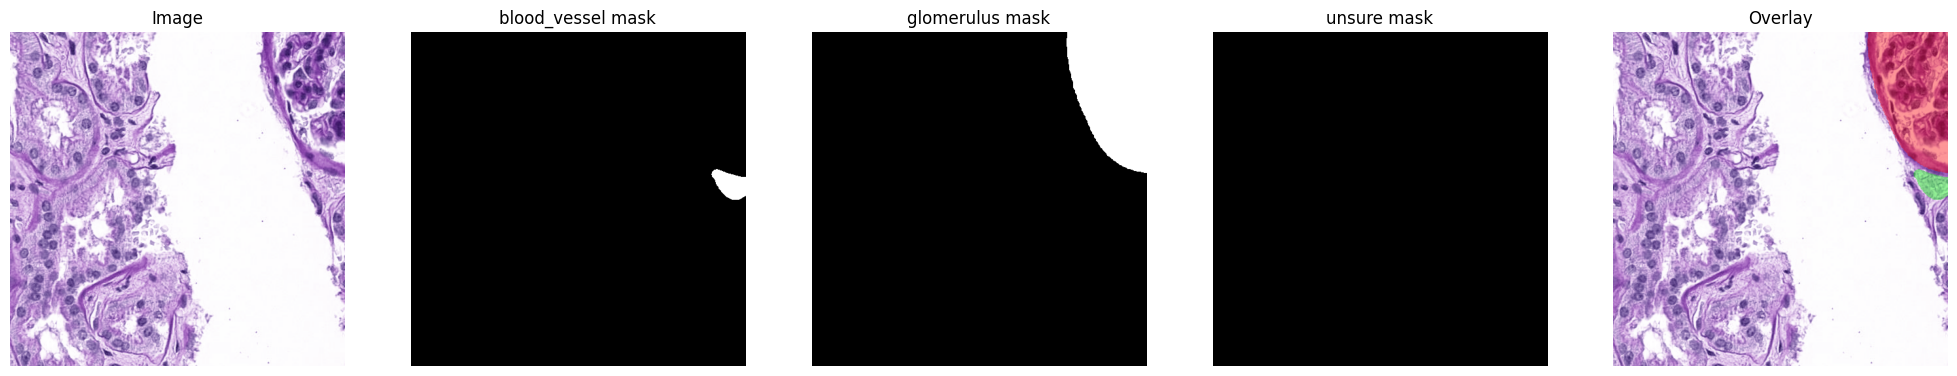

Annotation counts for image 0033bbc76b6b: {'blood_vessel': 3, 'glomerulus': 0, 'unsure': 1}


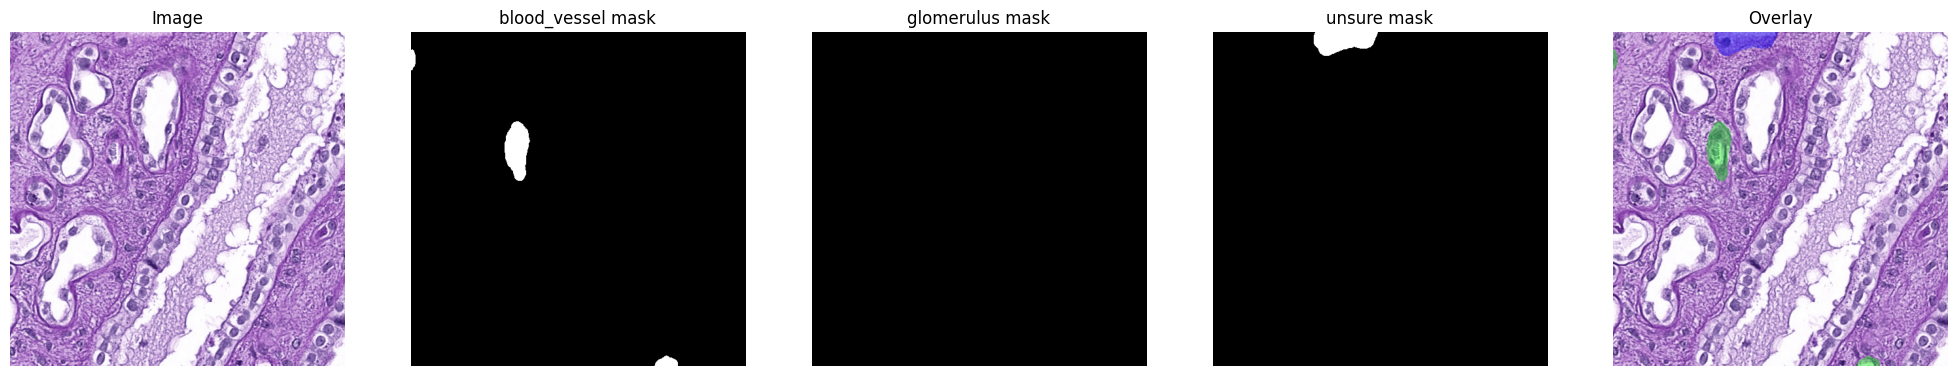

Annotation counts for image 003504460b3a: {'blood_vessel': 7, 'glomerulus': 0, 'unsure': 0}


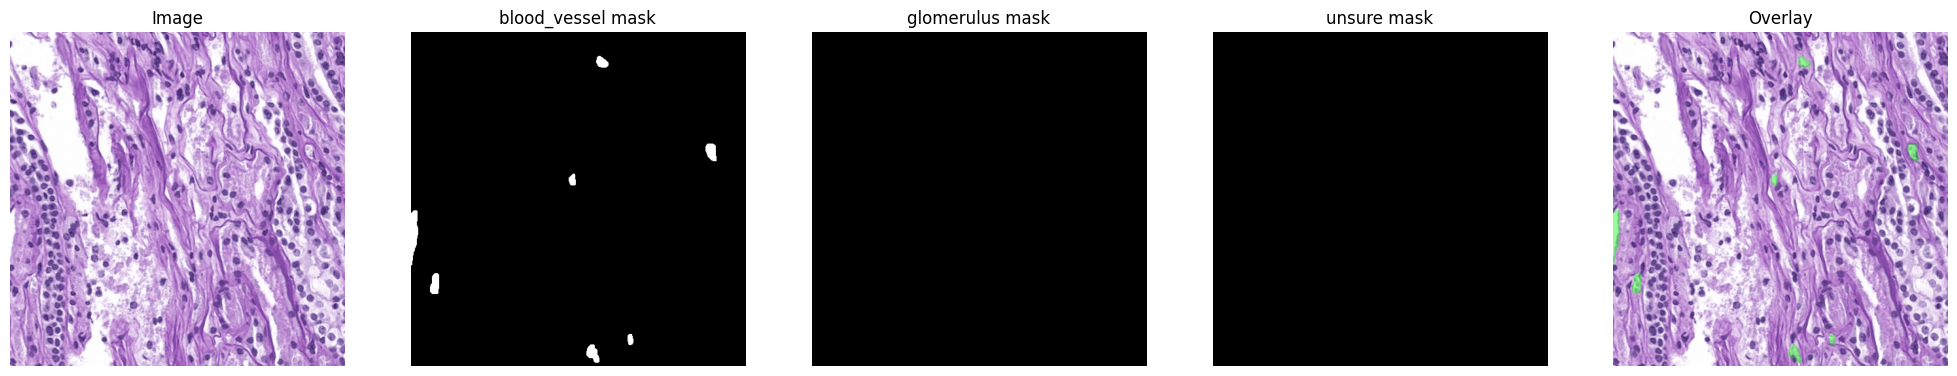

Annotation counts for image 004daf1cbe75: {'blood_vessel': 9, 'glomerulus': 1, 'unsure': 0}


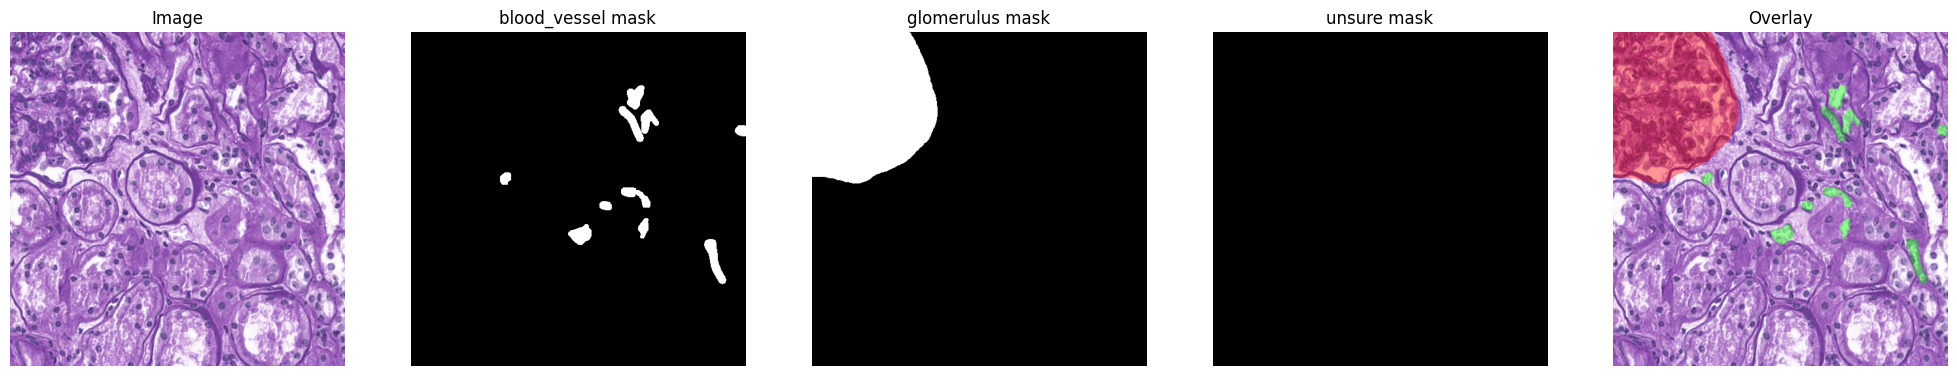

In [22]:
masks = {}
annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
for image_id in annotations.keys():
    if image_id in preprocessed_images:
        polygons = annotations[image_id]
        # Load the preprocessed image
        image = preprocessed_images[image_id]

        # Create an empty mask of the same size as the image
        masks[image_id] = {annotation_type: np.zeros(image.shape[:2], dtype=np.uint8) for annotation_type in annotation_types}

        # For each polygon
        for polygon in polygons:
            annotation_type = polygon['type']
            lines = np.array(polygon['coordinates'])
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            cv2.fillPoly(masks[image_id][annotation_type], [lines], 255)

        # Display the image and its masks if it's one of the first 5 images
        if len(masks) <= 5:
            display_images_masks_overlays(image, masks, image_id)

In [23]:
# Save preprocessed images
with open('/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/preprocessed_images.pkl', 'wb') as f:
    pickle.dump(preprocessed_images, f)

# Save binary masks
with open('/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/masks.pkl', 'wb') as f:
    pickle.dump(masks, f)